<center><a href="https://www.featuretools.com/"><img src="img/featuretools-logo.png" width="400" height="200" /></a></center>

<h2> A Featuretools Baseline </h2>
<p>The following tutorial illustrates a featuretools baseline model for the NYC Taxi Trip Duration competition on Kaggle. This notebook follows the structure of the previous worksheet, but uses deep feature synthesis to create the model.</p>

<h2>Step 1: Download raw data </h2>
<p>As always, if you have not yet downloaded the data it can be found at the <a href="https://www.kaggle.com/c/nyc-taxi-trip-duration/data">Kaggle website</a>. After installing featuretools following <a href = "https://docs.featuretools.com/">the instructions in the documentation</a> you can run the following.
</p>


In [1]:
import pandas as pd
import numpy as np
import featuretools as ft
import taxi_utils
ft.__version__

'0.22.0'

In [2]:
TRAIN_DIR = "data/train.csv"
TEST_DIR = "data/test.csv"

data_train, data_test = taxi_utils.read_data(TRAIN_DIR, TEST_DIR)

data_train.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,False,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,False,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,False,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,False,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,False,435


<h2>Step 2: Prepare the Data </h2>
<p>Let's create another column to define test and train datasets.</p>

In [3]:
data_train['test_data'] = False
data_test['test_data'] = True

<p>We can now combine the data. </p>

In [4]:
data = pd.concat([data_train, data_test], sort=True)

<h2>Step 3: Create baseline features using DFS </h2>
<p>Instead of manually creating features, such as month of <b>pickup_datetime</b>, we can let featuretools come up with them. </p>

<p>Within featuretools there is a standard format for representing data that is used to set up predictions and build features. A <b>EntitySet</b> stores information about entities (database table), variables (columns in database tables), relationships, and the data itself. </p>

<p> First, we create the EntitySet.</p>

In [5]:
es = ft.EntitySet("taxi")

<p>We can then use the `entity_from_dataframe` method to add an Entity called <i>trips</i>. We want to track the `id`, the `time_index` and specify other types of variables we care about in this entity. </p>

<p>As a note: Featuretools will try to interpret the types of variables. We can override this interpretation by specifying the types. In this case, I wanted <b>passenger_count</b> to be a type of Ordinal, and <b>vendor_id</b> to be of type Categorical.</p>

In [6]:
from featuretools import variable_types as vtypes

trip_variable_types = {
    'passenger_count': vtypes.Ordinal, 
    'vendor_id': vtypes.Categorical,
}

es.entity_from_dataframe(entity_id="trips",
                         dataframe=data,
                         index="id",
                         time_index='pickup_datetime',
                         variable_types=trip_variable_types)

Entityset: taxi
  Entities:
    trips [Rows: 2050266, Columns: 11]
  Relationships:
    No relationships

In [7]:
es['trips'].df

,id,dropoff_latitude,dropoff_longitude,pickup_datetime,pickup_latitude,pickup_longitude,store_and_fwd_flag,test_data,trip_duration,passenger_count,vendor_id
id0190469,id0190469,40.829182,-73.938828,2016-01-01 00:00:17,40.719158,-73.981743,False,False,849.0,5,2
id0621643,id0621643,40.769379,-73.969330,2016-01-01 00:00:22,40.716881,-73.981850,False,True,NaN,2,2
id1384355,id1384355,40.891788,-73.854263,2016-01-01 00:00:28,40.733562,-73.976501,False,True,NaN,1,1
id1665586,id1665586,40.717491,-73.958038,2016-01-01 00:00:53,40.747166,-73.985085,False,False,1294.0,1,1
id1210365,id1210365,40.815170,-73.947479,2016-01-01 00:01:01,40.801041,-73.965279,False,False,408.0,5,2
...,...,...,...,...,...,...,...,...,...,...,...
id3719493,id3719493,40.675968,-73.973160,2016-06-30 23:59:39,40.791576,-73.978416,False,False,2609.0,1,2
id2150126,id2150126,40.730469,-73.986427,2016-06-30 23:59:41,40.771900,-73.956070,False,True,NaN,1,2
id1217141,id1217141,40.729523,-73.986160,2016-06-30 23:59:47,40.737583,-73.997437,False,True,NaN,1,1
id3505355,id3505355,40.655403,-73.959808,2016-06-30 23:59:53,40.679993,-73.964203,False,True,NaN,1,1


<p>We can also normalize some of the columns to create new entities. So a <i>vendors</i> entity is created based on the unique values in the <i>vendor_id</i> column in <i>trips</i>.</p>

In [8]:
es.normalize_entity(base_entity_id="trips",
                    new_entity_id="vendors",
                    index="vendor_id")

es.normalize_entity(base_entity_id="trips",
                    new_entity_id="passenger_cnt",
                    index="passenger_count")

Entityset: taxi
  Entities:
    trips [Rows: 2050266, Columns: 11]
    vendors [Rows: 2, Columns: 2]
    passenger_cnt [Rows: 8, Columns: 2]
  Relationships:
    trips.vendor_id -> vendors.vendor_id
    trips.passenger_count -> passenger_cnt.passenger_count

<p>We can specify the time for each instance of the target_entity to calculate features. The timestamp represents the last time data can be used for calculating features by DFS. This is specified using a dataframe of cutoff times. Below we can see that the cutoff time for each trip is the pickup time.</p>

In [9]:
cutoff_time = es['trips'].df[['id', 'pickup_datetime']]

In [10]:
es.add_interesting_values()

## Visualize EntitySet

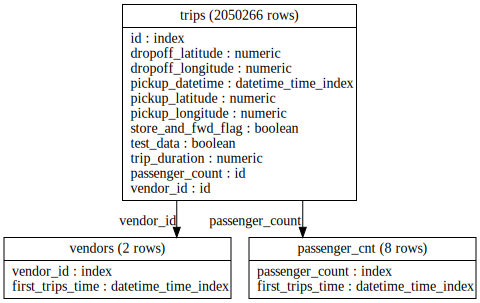

In [11]:
es.plot()

<p>Given this dataset, we would have about 2 million unique cutoff times. This is a good use case to use the approximate features parameter of DFS. In a large dataset, direct features that are aggregations on the prediction entity may not change much from cutoff time to cutoff time. Calculating the aggregation features at specific times every hour and using it for all cutoff times within the hour would save time and perhaps not lose much information. The approximate parameter in DFS lets you specify a window size to use when approximating these direct aggregation features.</p>

<p>We now create features using DFS.</p>

<b>Note, we can use an already calculated feature_matrix by doing the following:</b>
<p>You must copy and run the code.</p>

```python
feature_matrix = pd.read_csv('https://s3.amazonaws.com/featuretools-static/nyc_taxi/fm_simple.csv', 
                             index_col='id')
features = feature_matrix.columns.values
```

In [12]:
trans_primitives = ['Minute', 'Hour', 'Day', 'Week', 'Month', 'Weekday', 'Is_weekend']

feature_matrix, features = ft.dfs(entityset=es,
                                  target_entity="trips",
                                  trans_primitives=trans_primitives,
                                  drop_contains=['trips.test_data'],
                                  verbose=True,
                                  cutoff_time=cutoff_time,
                                  approximate='36d')

Built 98 features


c:\users\ajkramer\appdata\local\continuum\anaconda3\envs\predict_taxy\lib\site-packages\featuretools\synthesis\dfs.py:317: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  trans_primitives: ['Day', 'Hour', 'Is_weekend', 'Minute', 'Month', 'Week', 'Weekday']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible variable types for the primitive were found in the data.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


Elapsed: 02:03 | Progress: 100%|███████████████████████████████████████████████████████████████████████████████████████


<p>Here are the features created. Notice how some of the features match the manually created features in the previous notebook.</p>

In [13]:
print(len(features))

98


In [14]:
features[:25]

[<Feature: dropoff_latitude>,
 <Feature: dropoff_longitude>,
 <Feature: pickup_latitude>,
 <Feature: pickup_longitude>,
 <Feature: store_and_fwd_flag>,
 <Feature: test_data>,
 <Feature: trip_duration>,
 <Feature: passenger_count>,
 <Feature: vendor_id>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: vendors.COUNT(trips)>,
 <Feature: vendors.MAX(trips.dropoff_latitude)>,
 <Feature: vendors.MAX(trips.dropoff_longitude)>,
 <Feature: vendors.MAX(trips.pickup_latitude)>,
 <Feature: vendors.MAX(trips.pickup_longitude)>,
 <Feature: vendors.MAX(trips.trip_duration)>,
 <Feature: vendors.MEAN(trips.dropoff_latitude)>,
 <Feature: vendors.MEAN(trips.dropoff_longitude)>,
 <Feature: vendors.MEAN(trips.pickup_latitude)>]

<h2>Step 3: Build the Model </h2>

<p>We need to retrieve our labels for the train dataset, so we should merge our current feature matrix with the original dataset. </p>
<p>We also get the log of the trip duration so that a more linear relationship can be found.</p>

In [15]:
# separates the whole feature matrix into train data feature matrix, train data labels, and test data feature matrix 
X_train, labels, X_test = taxi_utils.get_train_test_fm(feature_matrix)
labels = np.log(labels.values + 1)

In [16]:
model = taxi_utils.train_xgb(X_train, labels)

[09:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:51:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	train-rmse:4.18926	valid-rmse:4.18899
[2]	train-rmse:3.51460	valid-rmse:3.51431
[3]	train-rmse:2.95293	valid-rmse:2.95259
[4]	train-rmse:2.49066	valid-rmse:2.49034
[5]	train-rmse:2.11012	valid-rmse:2.10984
[6]	train-rmse:1.79848	valid-rmse:1.79825
[7]	train-rmse:1.54423	valid-rmse:1.54415
[8]	train-rmse:1.32888	valid-rmse:1.32891
[9]	train-rmse:1.15386	valid-rmse:1.15405
[11]	train-rmse:0.91841	valid-rmse:0.91896
[12]	train-rmse:0.

In [24]:
model = taxi_utils.train_xgb(X_train, labels)

[09:39:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[09:39:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[1]	train-rmse:4.18926	valid-rmse:4.18899
[2]	train-rmse:3.51460	valid-rmse:3.51431
[3]	train-rmse:2.95293	valid-rmse:2.95259
[4]	train-rmse:2.49066	valid-rmse:2.49034
[5]	train-rmse:2.11012	valid-rmse:2.10984
[6]	train-rmse:1.79848	valid-rmse:1.79825
[7]	train-rmse:1.54423	valid-rmse:1.54415
[8]	train-rmse:1.32888	valid-rmse:1.32891
[9]	train-rmse:1.15386	valid-rmse:1.15405
[11]	train-rmse:0.91841	valid-rmse:0.91896
[12]	train-rmse:0.

[196]	train-rmse:0.39075	valid-rmse:0.40551
[197]	train-rmse:0.39075	valid-rmse:0.40551
[198]	train-rmse:0.39072	valid-rmse:0.40551
[199]	train-rmse:0.38995	valid-rmse:0.40475
[201]	train-rmse:0.38990	valid-rmse:0.40471
[202]	train-rmse:0.38989	valid-rmse:0.40471
[203]	train-rmse:0.38988	valid-rmse:0.40471
[204]	train-rmse:0.38986	valid-rmse:0.40471
[205]	train-rmse:0.38986	valid-rmse:0.40471
[206]	train-rmse:0.38983	valid-rmse:0.40469
[207]	train-rmse:0.38979	valid-rmse:0.40467
[208]	train-rmse:0.38971	valid-rmse:0.40465
[209]	train-rmse:0.38970	valid-rmse:0.40465
[211]	train-rmse:0.38968	valid-rmse:0.40464
[212]	train-rmse:0.38967	valid-rmse:0.40464
[213]	train-rmse:0.38965	valid-rmse:0.40464
[214]	train-rmse:0.38965	valid-rmse:0.40464
[215]	train-rmse:0.38964	valid-rmse:0.40463
[216]	train-rmse:0.38960	valid-rmse:0.40460
[217]	train-rmse:0.38959	valid-rmse:0.40460
[218]	train-rmse:0.38958	valid-rmse:0.40459
[219]	train-rmse:0.38957	valid-rmse:0.40459
[221]	train-rmse:0.38957	valid-r

## Step 4: Build the model automatically
<p align="center">
<img width=50% src="https://evalml-web-images.s3.amazonaws.com/evalml_horizontal.svg" alt="Featuretools" />
</p>






Up to now, we have been training a single xgboost model. However, there are many different model types that could be useful. Common ones include Catboost, LightGBM, and Random Forest Models. Using [EvalML](https://evalml.alteryx.com/en/stable/), an open source autoML library created by Alteryx, we can automatically build and tune multiple models, as well as compare the results 

In [17]:
import evalml
from evalml import AutoMLSearch

automl = AutoMLSearch(problem_type="regression", objective="root mean squared error")
automl.search(X_train, labels, data_checks='disabled')

Using default limit of max_batches=1.

`X` passed was not a DataTable. EvalML will try to convert the input as a Woodwork DataTable and types will be inferred. To control this behavior, please pass in a Woodwork DataTable instead.
`y` passed was not a DataColumn. EvalML will try to convert the input as a Woodwork DataTable and types will be inferred. To control this behavior, please pass in a Woodwork DataTable instead.
Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for Root Mean Squared Error. 
Lower score is better.

Searching up to 1 batches for a total of 8 pipelines. 
Allowed model families: extra_trees, random_forest, decision_tree, catboost, xgboost, linear_model



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/8) Mean Baseline Regression Pipeline        Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.751
Batch 1: (2/8) Decision Tree Regressor. w/ Imputer      Elapsed:00:06
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.633
Batch 1: (3/8) Extra Trees Regressor w/ Imputer         Elapsed:00:47
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.645
Batch 1: (4/8) XGBoost Regressor w/ Imputer             Elapsed:02:59
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.453
Batch 1: (5/8) CatBoost Regressor w/ Imputer            Elapsed:04:41
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.706
Batch 1: (6/8) Random Forest Regressor w/ Imputer       Elapsed:05:08
	Starting cross validation
	Finished cross validation - mean Root Mean Squared Error: 0.632
Batch 1: (7/8) Linear Regres

In [18]:
pipeline = automl.best_pipeline
pipeline.fit(X_train, labels)

GeneratedPipeline(parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'XGBoost Regressor':{'eta': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100},})

Notice that with evalML, we were able to create a model with a better RMSE than just building a simple xgboost model. In the last part of the demo, where we incorporate custom features, we will exclusively use evalML for model building

<h2>Step 4: Make a Submission </h2>

In [21]:
submission = pipeline.predict(X_test)
submission.head(5)

0    6.946520
1    7.531609
2    7.155881
3    6.948633
4    5.823598
dtype: float32

In [18]:
submission.to_csv('trip_duration_ft_simple.csv', index=True, index_label='id')

<h2>Additional Analysis</h2>
<p>Let's look at how important each feature was for the model.</p>

In [19]:
feature_names = X_train.columns.values
ft_importances = taxi_utils.feature_importances(model, feature_names)
ft_importances

,feature_name,importance
4,dropoff_latitude,8287.0
0,dropoff_longitude,7675.0
9,pickup_latitude,6207.0
3,pickup_longitude,5678.0
7,HOUR(pickup_datetime),2981.0
18,MINUTE(pickup_datetime),2111.0
27,DAY(pickup_datetime),2094.0
34,WEEK(pickup_datetime),1578.0
15,WEEKDAY(pickup_datetime),1356.0
10,IS_WEEKEND(pickup_datetime),400.0


<p align="center">
<img width=50% src="https://alteryx-open-source-images.s3.amazonaws.com/OpenSource_Logo-01.jpg" alt="ayx_os" />
</p>

Featuretools was created by the developers at [Alteryx](https://www.alteryx.com). If building impactful data science pipelines is important to you or your business, please [get in touch](https://www.alteryx.com/contact-us/).